In [161]:
import anndata as ad
import os
from SpatialQuery.spatial_query import spatial_query
from SpatialQuery.spatial_query_multiple_fov import spatial_query_multi
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

In [162]:
from os.path import join

In [163]:
data_path = "./data/HBM987_KWLK_254/"

# adata_expr = ad.read_h5ad(os.path.join(data_path, 'expr.h5ad'))
adata = ad.read_h5ad(join("data", "HBM987_KWLK_254", "secondary_analysis.h5ad"))
fig_size = (8, 4)

In [164]:
adata

AnnData object with n_obs × n_vars = 4058 × 26265
    obs: 'n_genes', 'n_counts', 'leiden', 'umap_density', 'predicted.ASCT.celltype', 'predicted.ASCT.celltype.score'
    var: 'hugo_symbol', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'annotation_metadata', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'umap_density_params'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'X_umap_proj'
    varm: 'PCs'
    layers: 'spliced', 'spliced_unspliced_sum', 'unscaled', 'unspliced'
    obsp: 'connectivities', 'distances'

In [165]:
spatial_key = 'X_spatial'
label_key = 'predicted.ASCT.celltype'

In [166]:
# Test building kd tree
tt = spatial_query(adata=adata, dataset = 'test', spatial_key=spatial_key, label_key=label_key, leaf_size=10)

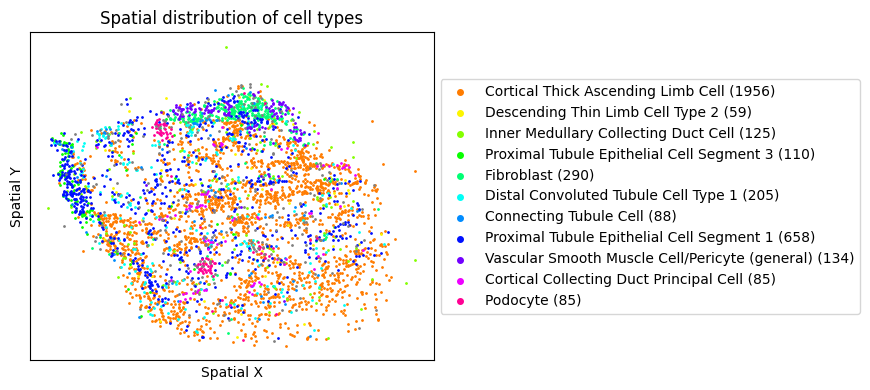

In [167]:
# tt.plot_fov(fig_size=fig_size)
tt.plot_fov(fig_size=fig_size)

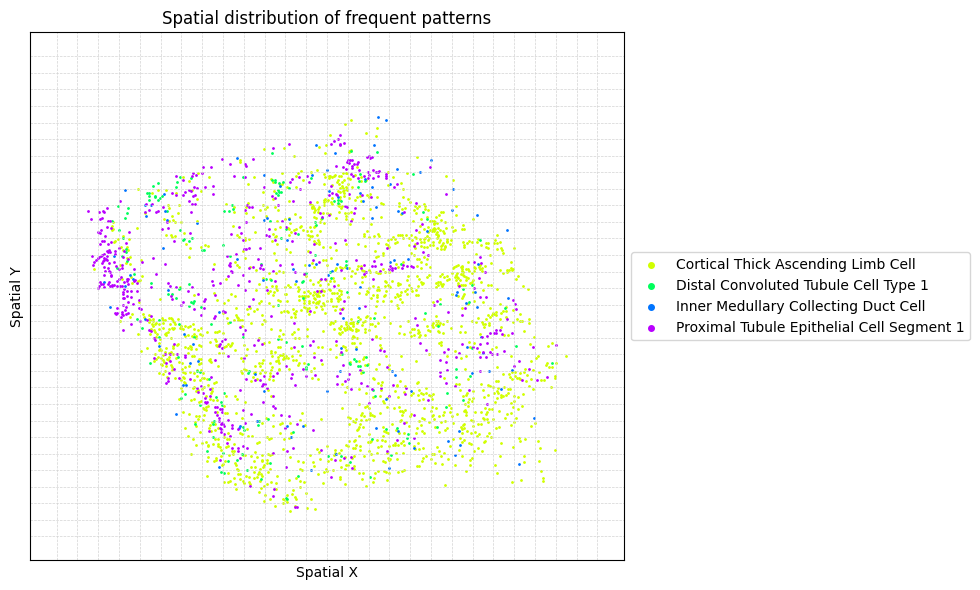

In [168]:
# Test frequent patterns of fov
max_dist = 150
min_size = 4
min_count = 10
min_support = 0.5
dis_duplicates=False # if distinguish duplicates of cell types in neighborhood


fp_tree =tt.find_patterns_grid(max_dist=max_dist,
                               min_size=min_size,
                               min_count=min_count,
                               min_support=min_support, 
                               dis_duplicates=dis_duplicates,
                               if_display=True,
                               fig_size = (9, 6),
                               return_cellID=True,
                              ) 

In [169]:
fp_tree

,support,itemsets,cell_id
0,0.538647,"(Cortical Thick Ascending Limb Cell, Proximal Tubule Epithelial Cell Segment 1, Distal Convoluted Tubule Cell Type 1)","{0, 2, 5, 6, 9, 16, 20, 21, 22, 23, 24, 27, 28, 32, 36, 37, 38, 44, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 71, 73, 76, 77, 80, 82, 83, 85, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 104, 105, 106, 109, 110, 111, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 138, 142, 144, 146, 147, 148, 150, 158, 159, 160, 161, 162, 163, 164, 165, 169, 170, ...}"
1,0.526570,"(Cortical Thick Ascending Limb Cell, Inner Medullary Collecting Duct Cell)","{0, 2, 5, 6, 9, 11, 21, 22, 24, 28, 35, 36, 37, 38, 43, 45, 48, 51, 52, 53, 54, 55, 57, 58, 60, 62, 64, 67, 73, 74, 75, 76, 77, 82, 83, 84, 88, 89, 92, 96, 97, 99, 100, 103, 109, 111, 114, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 134, 136, 138, 140, 144, 145, 146, 148, 156, 160, 162, 163, 169, 170, 176, 177, 180, 182, 183, 191, 193, 194, 196, 202, 205, 206, 211, 212, 217, 222, 223, 224, 228, 229, 230, 234, 235, 242, 246, ...}"


In [172]:
additional_obs_sets = {
    "version": "0.1.3",
    "tree": [
        {
            "name": "Spatial-Query Results",
            "children": [
                
            ]
        }
    ]
}

obs_set_color = [
    {
        "color": [255, 255, 255],
        "path": ["Cell Type"],
    },
    {
        "color": [255, 255, 255],
        "path": ["Spatial-Query Results"],
    }
]

for cell_type in adata.obs[label_key].unique().tolist():
    color = [255, 0, 0] # TODO: use matplotlib palette
    path = ["Cell Type", cell_type]
    obs_set_color.append({
        "color": color,
        "path": path
    })

cell_i_to_cell_id = dict(zip(range(adata.obs.shape[0]), adata.obs.index.tolist()))
cell_id_to_cell_type = dict(zip(adata.obs.index.tolist(), adata.obs[label_key].tolist()))

def get_matching_cell_ids(cell_type, cell_i):
    cell_ids = [ cell_i_to_cell_id[i] for i in cell_i ]
    matches = []
    for cell_id in cell_ids:
        cell_ct = cell_id_to_cell_type[cell_id]
        if cell_ct == cell_type:
            matches.append([cell_id, None])
    return matches

for row_i, row in fp_tree.iterrows():
    motif = row["itemsets"]
    cell_i = row["cell_id"]

    motif_name = str(list(motif))

    additional_obs_sets["tree"][0]["children"].append({
        "name": motif_name,
        "children": [
            {
                "name": cell_type,
                "set": get_matching_cell_ids(cell_type, cell_i)
            }
            for cell_type in motif
        ]
    })

    obs_set_color.append({
        "color": [255, 255, 255],
        "path": [additional_obs_sets["tree"][0]["name"], motif_name]
    })

    for cell_type in motif:
        color = [255, 0, 0] # TODO: use matplotlib palette
        path = [additional_obs_sets["tree"][0]["name"], motif_name, cell_type]
        obs_set_color.append({
            "color": color,
            "path": path
        })
        

In [173]:
from vitessce import (
    VitessceConfig,
    AnnDataWrapper,
    ViewType as vt,
    CoordinationType as ct,
)

In [174]:
zarr_path = join("data", "HBM987_KWLK_254", "secondary_analysis.h5ad.zarr")
adata.write_zarr(zarr_path)

/Users/mkeller/software/miniconda3/envs/spatial-query/lib/python3.11/site-packages/zarr/creation.py:295: UserWarning: ignoring keyword argument 'maxshape'
  warn("ignoring keyword argument %r" % k)


In [175]:
vc = VitessceConfig(schema_version="1.0.16", name="Spatial-Query")
dataset = vc.add_dataset("Query results").add_object(AnnDataWrapper(
    adata_path=zarr_path,
    obs_feature_matrix_path="X",
    obs_set_paths=["obs/predicted.ASCT.celltype"],
    obs_set_names=["Cell Type"],
    obs_spots_path="obsm/X_spatial",
    coordination_values={
        "obsType": "spot",
    }
))

spatial_view = vc.add_view("spatialBeta", dataset=dataset)
lc_view = vc.add_view("layerControllerBeta", dataset=dataset)
sets_view = vc.add_view("obsSets", dataset=dataset)
features_view = vc.add_view("featureList", dataset=dataset)

vc.link_views([spatial_view, lc_view, sets_view, features_view], ["obsType"], ["spot"])
vc.link_views([spatial_view, lc_view, sets_view, features_view], ["additionalObsSets", "obsSetColor"], [additional_obs_sets, obs_set_color])


vc.set_coordination_value("spatialSpotRadius", "init_A_obsSpots_0", 15)

vc.layout((spatial_view | lc_view) / (sets_view | features_view));

In [176]:
vc.widget(height=900)

/Users/mkeller/software/miniconda3/envs/spatial-query/lib/python3.11/site-packages/traitlets/traitlets.py:842: DeprecationWarning: Deprecated in traitlets 4.1, use the instance .metadata dictionary directly, like x.metadata[key] or x.metadata.get(key, default)
  warn("Deprecated in traitlets 4.1, " + msg, DeprecationWarning, stacklevel=2)
/Users/mkeller/software/miniconda3/envs/spatial-query/lib/python3.11/site-packages/traitlets/traitlets.py:842: DeprecationWarning: Deprecated in traitlets 4.1, use the instance .metadata dictionary directly, like x.metadata[key] or x.metadata.get(key, default)
  warn("Deprecated in traitlets 4.1, " + msg, DeprecationWarning, stacklevel=2)


VitessceWidget(config={'version': '1.0.16', 'name': 'Spatial-Query', 'description': '', 'datasets': [{'uid': '…